In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'forestfires.csv'
df = pd.read_csv(file_path)

# Remove the specified columns
df.drop(columns=['rain', 'X', 'Y', 'day'], inplace=True)

# Convert months to a binary summer category
def is_summer(month):
    return int(month in ['jun', 'jul', 'aug'])

df['is_summer'] = df['month'].apply(is_summer)
df.drop(columns='month', inplace=True)

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]

# Remove outliers
numeric_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'area']
df = remove_outliers_iqr(df, numeric_features)

# Apply log transformation to the target variable
df['log_area'] = np.log1p(df['area'])  # log1p is used to handle log(0)

# Create new features
df['temp_RH_interaction'] = df['temp'] * df['RH']
df['wind_ISI_interaction'] = df['wind'] * df['ISI']

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[numeric_features[:-1]])
poly_feature_names = [f"poly_{i}" for i in range(poly_features.shape[1])]

# Combine polynomial features with the original data
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
df = pd.concat([df, df_poly], axis=1)

# Check for and handle NaN or infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Split the data into features and target
X = df.drop(columns=['area', 'log_area'])
y = df['log_area']

# Normalize the numeric features
scaler = StandardScaler()
X[numeric_features[:-1]] = scaler.fit_transform(X[numeric_features[:-1]])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
# With three lines of code, we can start using this economical and fast AutoML engine as a scikit-learn style estimator.
# Import The AUTO_ML
from flaml import AutoML

# Initlize The autoML
autoML = AutoML()
# Fit autoML on Data
autoML.fit(X_train, y_train, task="classification",metric='roc_auc_ovo',time_budget=60*3)

[flaml.automl.logger: 06-07 14:48:43] {1680} INFO - task = classification
[flaml.automl.logger: 06-07 14:48:43] {1691} INFO - Evaluation method: cv


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[flaml.automl.logger: 06-07 14:48:45] {1789} INFO - Minimizing error metric: 1-roc_auc_ovo
[flaml.automl.logger: 06-07 14:48:45] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-07 14:48:45] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-07 14:48:59] {2345} INFO - Estimated sufficient time budget=136442s. Estimated necessary time budget=3350s.
[flaml.automl.logger: 06-07 14:48:59] {2392} INFO -  at 16.1s,	estimator lgbm's best error=0.0012,	best estimator lgbm's best error=0.0012
[flaml.automl.logger: 06-07 14:48:59] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-07 14:49:13] {2392} INFO -  at 29.7s,	estimator lgbm's best error=0.0012,	best estimator lgbm's best error=0.0012
[flaml.automl.logger: 06-07 14:49:13] {2219} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 06-07 14:49:26] {2392} INFO -  at 43.2s,	estimator lg

In [3]:
print(f'Best AutoML Model: {autoML.best_estimator}\n')
print(f'Best Paramter AutoML Model:\n {autoML.best_config}\n')
print(f'Best roc_auc_ovo On Val data: {1 - autoML.best_loss:.4g}\n')
print(f'Best Run Training duration: {autoML.best_config_train_time:.4g} s\n')

Best AutoML Model: lgbm

Best Paramter AutoML Model:
 {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.26770501231052046, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.001348364934537134, 'reg_lambda': 1.4442580148221913}

Best roc_auc_ovo On Val data: 0.9992

Best Run Training duration: 0.04746 s



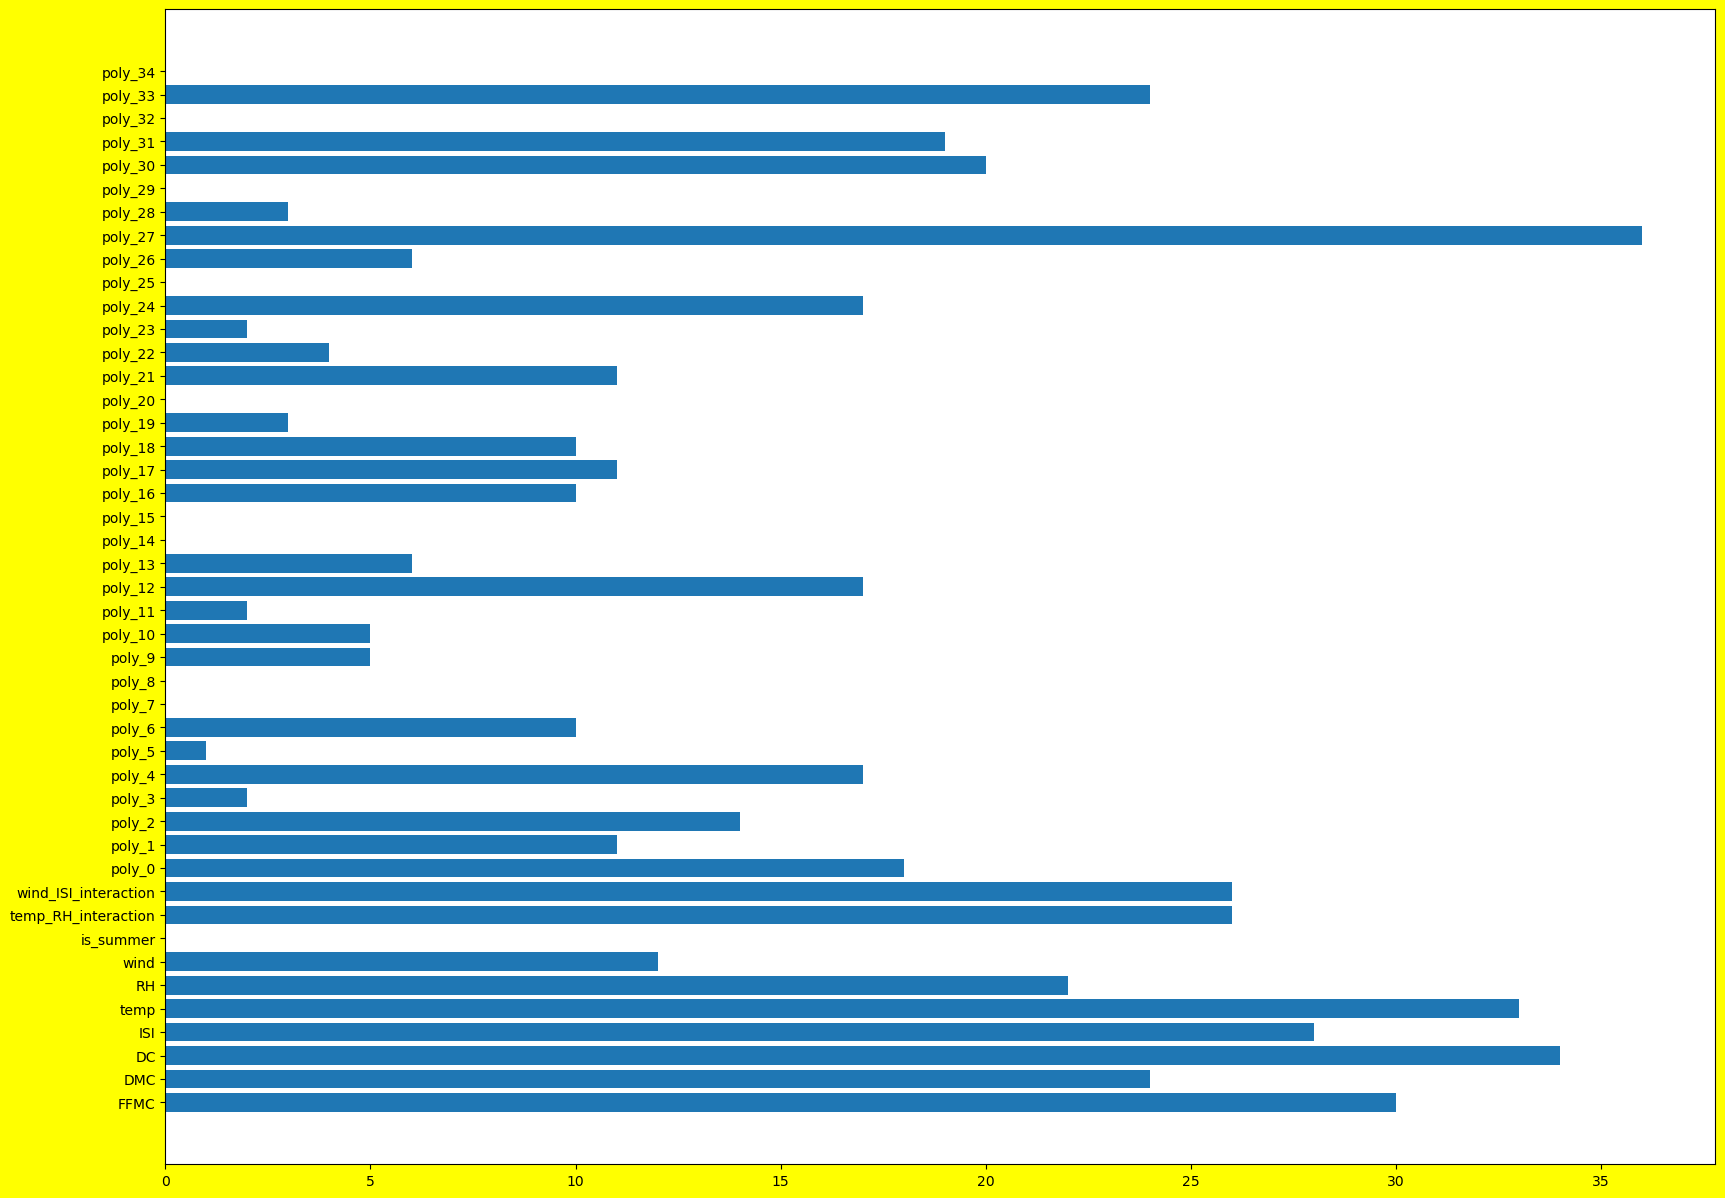

In [4]:
# Feature importance
plt.figure(figsize=((20,15)), facecolor='yellow')  # Set background color to yellow
plt.barh(
    autoML.model.estimator.feature_name_, autoML.model.estimator.feature_importances_
)
plt.show()

In [5]:
# Test Prediction
auto_P = autoML.predict(X_test)

# Making Submission File
d_s = pd.DataFrame(data={'Id': X_test.index, 'Predicted': auto_P})
d_s.to_csv('Flaml_Submission.csv', index=False)

print("Submission File Saved")

Submission File Saved


In [6]:
# Measure performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions on the test set
y_pred = autoML.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2): {r2:.4f}')


Mean Absolute Error (MAE): 0.6866
Mean Squared Error (MSE): 1.0938
R-squared (R2): -0.5003
